In [93]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch
from torch import optim
from torch.optim import SGD, Adam
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
%matplotlib inline


In [94]:
device = "cuda" if torch.cuda.is_available() else "else"
data_folder = "~\\data\\FMNIST"
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

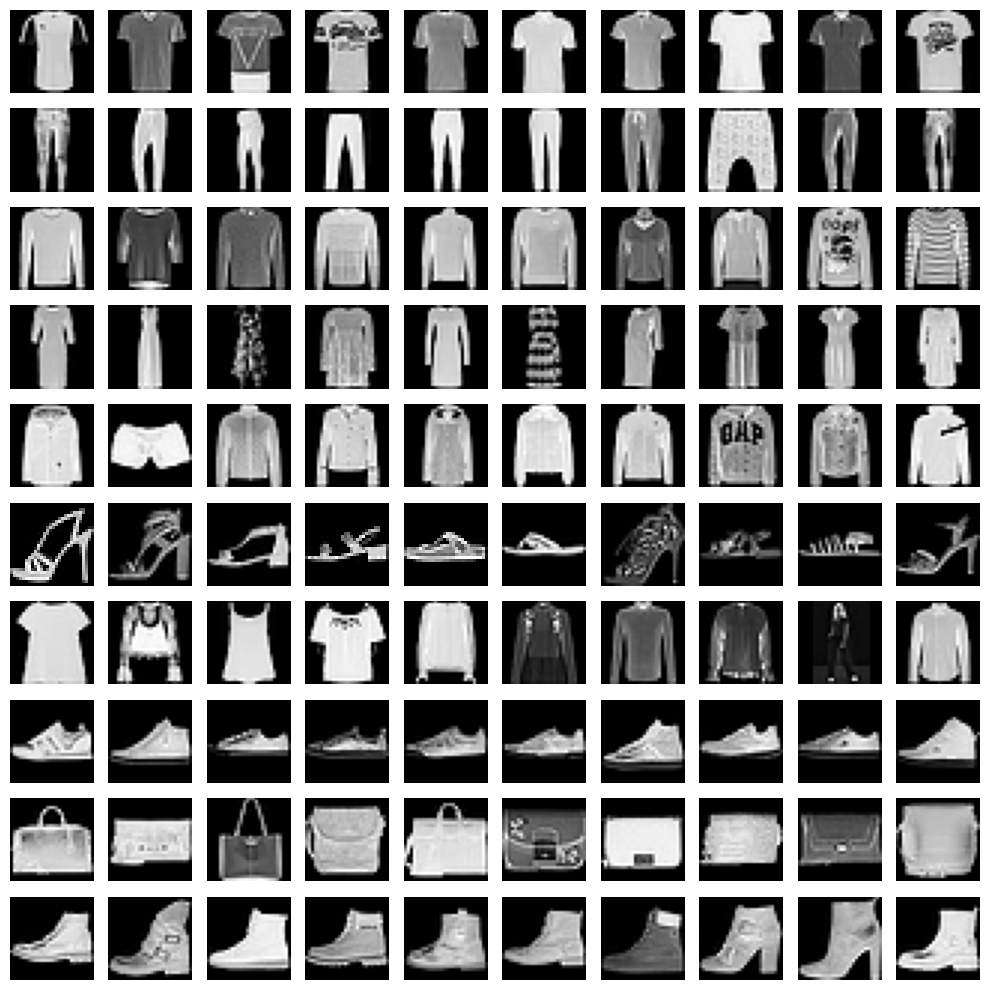

In [95]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10, 10))
for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False)
        plot_cell.axis("off")
        idx = np.random.choice(label_x_rows)
        x, y = tr_images[idx], tr_targets[idx]
        plot_cell.imshow(x, cmap="gray")
plt.tight_layout()

In [96]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / 255
        x = x.view(-1, 28 * 28)
        self.x, self.y = x, y

    def __getitem__(self, idx):
        x, y = self.x[idx], self.y[idx]
        return x.to(device), y.to(device)

    def __len__(self):
        return len(self.x)


def getData():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl


def getModel():
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28 * 28, 1000), 
        nn.ReLU(), 
        nn.Dropout(0.25),
        nn.Linear(1000, 10)).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.01)
    return model, loss_fn, optimizer


def train_batch(x, y, model, optimizer, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()


@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def val_loss(x, y, model, loss_fn):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [97]:
trn_dl, val_dl = getData()
model, loss_fn, optimizer = getModel()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=0,threshold=0.001,verbose=True,min_lr=1e-5,threshold_mode='abs')

losses, accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
    print(f"Current epoch: {epoch+1}")
    epoch_losses, epoch_accuracies = [], []
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)
    epoch_loss = np.array(epoch_losses).mean()
    for idx, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracy = np.mean(epoch_accuracies)
    for idx, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model, loss_fn)
        scheduler.step(validation_loss)
    val_epoch_accuracy = np.mean(val_is_correct)

    losses.append(epoch_loss)
    accuracies.append(epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)
    
    print(f"the train loss: {epoch_loss}, the train accuracy: {epoch_accuracy}")
    print(f"the val loss: {validation_loss}, the val accuracy: {val_epoch_accuracy}")

Current epoch: 1
the train loss: 0.6961765352487564, the train accuracy: 0.8136666666666666
the val loss: 0.5367022752761841, the val accuracy: 0.8039
Current epoch: 2
Epoch 00002: reducing learning rate of group 0 to 5.0000e-03.
the train loss: 0.6296991976896922, the train accuracy: 0.8256
the val loss: 0.547010600566864, the val accuracy: 0.8153
Current epoch: 3
the train loss: 0.5410194099903106, the train accuracy: 0.8528333333333333
the val loss: 0.4601176381111145, the val accuracy: 0.8403
Current epoch: 4
the train loss: 0.5250958564043045, the train accuracy: 0.8566833333333334
the val loss: 0.4388907849788666, the val accuracy: 0.8426
Current epoch: 5
Epoch 00005: reducing learning rate of group 0 to 2.5000e-03.
the train loss: 0.5123484629631042, the train accuracy: 0.8592666666666666
the val loss: 0.4462944269180298, the val accuracy: 0.8438
Current epoch: 6
the train loss: 0.47280876995722454, the train accuracy: 0.8705333333333334
the val loss: 0.41111084818840027, the va

ValueError: x and y must have same first dimension, but have shapes (5,) and (10,)

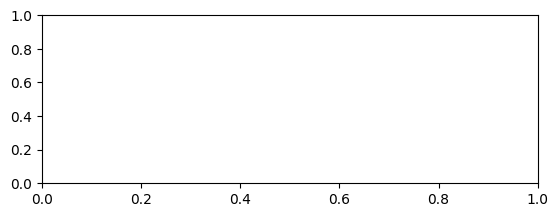

In [98]:
epochs = np.arange(5) + 1

# plt.figure(figsize=(20, 5))
# plt.subplot(121)
# plt.title('Loss value over increasing epochs')
# plt.plot(epochs, losses, label='Training Loss')
# plt.legend()

# plt.subplot(122)
# plt.title('accuracy value over increasing epochs')
# plt.plot(epochs, accuracies, label='Training Accuracy')
# plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
# plt.legend()

plt.subplot(211)
plt.plot(epochs, losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and Validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()